<a href="https://colab.research.google.com/github/claudioalvesmonteiro/machinelearning-CNPJ/blob/master/modelos/MODELO_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Machine Learning para Análise de Crédito
## Modelo de XGBoost
### Equipe:
####Claudio Alves Monteiro
####Marcos Antonio Almeida Souto Júnior
####Virgínia Heimann
####Kayo Renato da Silva Nascimento


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://mirror.nbtelecom.com.br/apache/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import time
import pickle
import os
from sklearn import metrics
from sklearn.base import clone
from xgboost import XGBClassifier
import xgboost as xgb

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# import data
path = 'drive/My Drive/Colab Notebooks/ProjetoCESARSchool/codes/data/'

df = spark.read.csv(path+'model_data_ANTIGO.csv',
                    sep=',',
                    encoding='utf-8',
                    header=True,
                    inferSchema=True)

## Configuração do ambiente

In [0]:
# local onde serão salvo os modelos
model_path = 'drive/My Drive/Colab Notebooks/ProjetoCESARSchool/codes/data/'
database_path = 'drive/My Drive/Colab Notebooks/ProjetoCESARSchool/codes/data/'
if not os.path.exists(model_path):
    os.mkdir(model_path)

if not os.path.exists(database_path):
    os.mkdir(database_path)

### Base de dados

In [0]:
# Bases de dados

In [0]:
full_database_name = "model_data_ANTIGO.csv"
trn_database_name = database_path + "train_75.csv"
tst_database_name = database_path + "test_25.csv"

In [0]:
#======== VECTOR ASSEMBLER

from pyspark.ml.feature import VectorAssembler

inputcol = ['QTD_SOCIOS',
           'log_capital_social',
           'log_idade',
           'tipo_index',
           'natureza_socied_limitada',
           'natureza_empresario_indiv',
           'natureza_empresa_indiv_limitada',
           'situacao_ativa',
           'situacao_baixada',
           'atividade_alimento',
           'UF_encoded'
           ]

assembler = VectorAssembler(
    inputCols = inputcol,
    outputCol = "features")

dataModel = assembler.transform(df)

dataModel = dataModel.withColumnRenamed('CS_ALVO', 'label')

dataModel = dataModel.select('features', 'label')


dataModel.show(5, truncate=False)


#X_train = pd.read_csv(trn_database_name, sep="\t")
#X_test = pd.read_csv(tst_database_name, sep="\t")

# Split the data into training and test sets (30% held out for testing)
(X_train, X_test) = dataModel.randomSplit([0.7, 0.3])

IllegalArgumentException: ignored

### Ler a base de dados e divide em treinamento e teste

In [0]:
df = pd.read_csv(full_database_name, sep= "\t")
df = shuffle(df)
X_train, X_test = train_test_split(df, test_size=0.25)
X_train.to_csv(trn_database_name, sep='\t',header='True',index=False)
X_test.to_csv(tst_database_name, sep='\t',header='True',index=False)

In [0]:
X_train.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Turcin, Mr. Stjepan",male,36.0,0,0,349247,7.8958,NaN,S
1,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S
2,1,3,"Niskanen, Mr. Juha",male,39.0,0,0,STON/O 2. 3101289,7.9250,NaN,S
3,1,3,"Asplund, Miss. Lillian Gertrud",female,5.0,4,2,347077,31.3875,NaN,S
4,0,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,NaN,S


### Variáveis do problema

In [0]:
# Variaveis da base
irrelevant_columns = ['name', 'ticket', 'cabin']

label_column = "survived"

## Pré-processamento

o arquivo **cesar_school_lib.py** contem algumas classes que podem ser usadas no pré-preprocessamento.

* Remover colunas irrelevantes;

   * RemoveIrrelevantColumns(irrelevant_columns): Remove colunas irrelevantes para o problema

* Tratamento de outliers para variáveis categóricas;

    * CategoricalOutilers: Todo valor que tenha representatividade menor que 1% da base é convertido para “OUTROS”. 

* Tratamento de missing:
    
   * Numérico
      
      * NumericalImputer: Converte o missing para a média da variável;
      
   * Categórico
   
       * CategoricalImputer: Adiciona um valor para representar o missing;
       
* Converter categórico para numérico:
        
    * CategoricalToNumerical(method) : https://contrib.scikit-learn.org/categorical-encoding/?source=post_page
    * Method:
        * "BackwardDifferenceEncoder"
        * "BaseNEncoder"
        * "BinaryEncoder"
        * "CatBoostEncoder"
        * "HashingEncoder"
        * "HelmertEncoder"
        * "JamesSteinEncoder"
        * "LeaveOneOutEncoder"
        * "MEstimateEncoder"
        * "OneHotEncoder"
        * "OrdinalEncoder"
        * "SumEncoder"
        * "PolynomialEncoder"
        * "TargetEncoder"
        * "WOEEncoder"
   
* Normalização:
    
    * MinMaxScaler: Normaliza as variáveis do problema para o intervalo entre 0 e 1.


## Pipeline

* A ideia do pipeline é criar um objeto que aplica um ou mais transformadores em sequência e no final um estimador.

> **Reumindo: Você consegue em um único artefato empacotar tanto o pré-processamento quanto o modelo de machine learning.**


* Tanto o skitlearn quanto o spark suportam esse conceito.

* Facilita colocar o modelo em produção, principalmente com a utilização de docker.
* Toda classe que pode ser utilizada no pipeline possui dois métodos:
    * **fit**: Aprende o que fazer com os dados. Deve-se utilizar a base de treinamento
    * **transform**: Aplica o que aprendeu em qualquer base com as mesmas variáveis.


### Pipeline de pré-processamento

In [0]:
import cesar_school_lib as cs
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
        ('irrelevants', cs.RemoveIrrelevantColumns(irrelevant_columns)),
        ('categorical_outliers', cs.CategoricalOutilers()),
        ('categorical_missing', cs.CategoricalImputer()),
        ('numerical_missing', cs.NumericalImputer()),
        ('categorical_to_numerical', cs.CategoricalToNumerical("OneHotEncoder")),
        ('cast_to_float', cs.FeaturesToFloat()),
        ('normalization', cs.MinMaxScaler())
])

## Treinamento

### XGBoost

* Algoritmo baseado no gradiente boosting (https://github.com/dmlc/xgboost);
    * Ensemble de árvores de decisão
    * Egenharia dele é mais eficiente que o gradient boosing
    * Usa uma estratégia diferente para regularização. 
* As abordagens derivadas do gradient boosting dominam comppetições como o kaagle
    * Outas abordagens são: ligthGBM e catboost
* Possui implementações em:
    * python
    * java
    * scala
    * spark
* Suporte a treinamentos com GPU

### Parâmetros do xgboost

https://xgboost.readthedocs.io/en/latest/parameter.html

* num_round
> Número máximo de árvores a serem criadas
* min_child_weight:
> Soma mínima de pesos em cada nó de uma árvore.
* max_depth
> Profundidade máxima de uma árvore;
* eta
> Taxa de aprendizado
* subsample
> Taxa de reamostragem dos indivíduos em cada iteração
*colsample_bytree
> Taxa de reamostragem das variáveis em cada iteração
* alpha
> Regularização L1
* lambda
> Rgularização L2
* scale_pos_weight
> Controla o balanceamento entre as classes. 
> * sum(negative instances) / sum(positive instances)
* objective
> Especifica o tipo de problema que será resolvido pelo xgboost. 
> * Para problemas binários: binary:logistic
* tree_method
> Algoritmo de construção da árvore
> * hist : Baseado em histograma e é a abordagem mais eficiente 


In [0]:
# Separa as variáveis do label
X = X_train.drop(label_column, axis=1)
y = X_train[label_column]

# Definição dos parâmetros
num_positives = np.sum(y) * 1.0
num_negatives = len(y) - num_positives
scale_pos_weight = num_negatives / num_positives
 
params = {}
params['num_round']= 500
params['max_depth'] = 7
params['min_child_weight'] = 3.0
params['subsample'] = 1.0
params['colsample_bytree'] = 1.0
params['reg_lambda'] = 1
params['reg_alpha'] = 1
params['eta'] = 0.01


# Instancia o xgboost
simple_xgb_model = XGBClassifier(n_estimators=params["num_round"],
                                 max_depth=int(params['max_depth']),
                                 min_child_weight=params['min_child_weight'],
                                 learning_rate=params['eta'],                                
                                 colsample_bytree=params['colsample_bytree'],
                                 reg_lambda=params['reg_lambda'],
                                 scale_pos_weight=scale_pos_weight,
                                 subsample=params['subsample'],
                                 reg_alpha=params['reg_alpha'],
                                 silent=False,
                                 objective='binary:logistic',                                
                                 eval_metric='auc',
                                 kvargs={'tree_method': 'hist'})

# Clona o pipeline
simple_pipeline = clone(pipeline)
                                   
simple_pipeline.steps.append(['xgb', simple_xgb_model])

simple_pipeline.fit(X, y)

# Salva o modelo
cs.write(simple_pipeline, model_path + "exp1.pkl")

#### Escoragem

In [0]:
train_scores = cs.predict(simple_pipeline, X_train)
test_scores = cs.predict(simple_pipeline, X_test)

In [0]:
test_scores.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,SCORES
0,0,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,NaN,S,0.044372
1,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,0.634013
2,0,3,"Calic, Mr. Jovo",male,17.0,0,0,315093,8.6625,NaN,S,0.251971
3,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,0.149667
4,0,3,"Vanden Steen, Mr. Leo Peter",male,28.0,0,0,345783,9.5000,NaN,S,0.064696
5,0,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.7500,NaN,Q,0.852295
6,1,1,"Daniel, Mr. Robert Williams",male,27.0,0,0,113804,30.5000,NaN,S,0.500207
7,0,2,"Laroche, Mr. Joseph Philippe Lemercier",male,25.0,1,2,SC/Paris 2123,41.5792,NaN,C,0.085586
8,1,2,"Troutt, Miss. Edwina Celia ""Winnie""",female,27.0,0,0,34218,10.5000,E101,S,0.965543
9,0,1,"Gee, Mr. Arthur H",male,47.0,0,0,111320,38.5000,E63,S,0.121716


#### Avaliação dos scores

/home/wso/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/wso/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


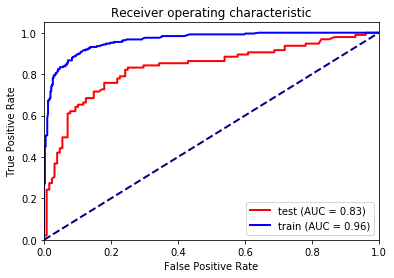

In [0]:
# Calcula o ks para a base de treinamento
train_ks = cs.ks(X_train[label_column].as_matrix(), train_scores["SCORES"].as_matrix())

# Calcula o ks para a base de teste
test_ks = cs.ks(X_test[label_column].as_matrix(), test_scores["SCORES"].as_matrix())

# calcula a área da curva roc das bases de treinamento e teste
data = {}
data["train"] = {"label": X_train[label_column], "scores": train_scores["SCORES"]}
data["test"] = {"label": X_test[label_column], "scores": test_scores["SCORES"]}
aucs = cs.roc_curve(data)

train_auc = aucs['train']
test_auc = aucs['test']

#### Visualização dos resultados

In [0]:
data = [['train', train_auc, train_ks], ['test', test_auc, test_ks]] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Database', 'AUC', 'KS']) 

df.head()

,Database,AUC,KS
0,train,0.963221,0.799
1,test,0.831826,0.582


## Treinamento com seleção dos parâmetros do xgboost

In [0]:
* Importante para evitar o ajuste manual (demorado) dos parâmetros

* Consiste em testar automaticamente a os valores e a combinação dos parâmetros

* É necessário definir a estratégia de seleção de parâmetros, a métrica de avaliação e a abordagem de avaliação de cada combinação de parâmetros. 

* Dentre as estratégias:

    * **Grid-search**
    * Random-search
    * Métodos de otimização: bayesian otimization, algoritmos genéticos,PSO, etc.
    
* Dentre as métricas de avaliação
    * Baseadas em erro: erro médio quadrado, erro absoluto, etc.
    * **AUC**
    * KS
    * f1-metric

* Abordagem de avaliação
    * Treina com a base de treinamento e avalia na base de validação;
    * **K-fold Cross-validation**: Divide a base em k fols. Utiliza k-1 folds para treinar e avalia com o fold restante. Se existem 3 folds, irão ser realizados 3 treinamentos para cada combinação de parâmetros. A avaliação final é a médias das 3 avaliações.

## Tratamento de overfitting

In [0]:
* O que é overfitting?

<p align="left">
 <img src="./standard_curve.png">
</p>

### Treinamento utilizando grid-search[auc], cross-validation (k=3) e sem overfitting

In [0]:
params = {}
params['num_round']=  300
params['max_depth']= [1, 2, 3]
params['min_child_weight']= [1.0, 2.0, 3.0, 4.0, 5.0]
params['eta'] = [0.001, 0.01, 0.1]
params['colsample_bytree']=  [0.85, 0.95]
params['subsample']=  [0.7, 0.85, 0.95]

params['reg_lambda']= 0.0001
params['reg_alpha']= 0.0001


params['early_stopping_rounds'] = 10


### Grid-search 

In [0]:
pipeline.fit(X)
X_ = pipeline.transform(X)
    
dtrain = xgb.DMatrix(X_, label=y)
    
def xgb_evaluate(max_depth, min_child_weight, subsample, colsample_bytree, eta, reg_lambda,
                 reg_alpha, num_round, early_stopping_rounds):
    
    max_depth = int(max_depth)
    if (max_depth < 1):
        max_depth = 1

    out_params = {'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'eta': eta,
               'subsample': subsample,               
               'reg_alpha': reg_alpha,
               'reg_lambda': reg_lambda,
               'scale_pos_weight': scale_pos_weight,
               'colsample_bytree': colsample_bytree,
               'eval_metric': 'auc',
               'tree_method': "hist",
               'objective': 'binary:logistic',
               'nthread': 4
               }

    cv_result = xgb.cv(out_params, dtrain, num_boost_round=int(num_round), nfold=3,
                       early_stopping_rounds=early_stopping_rounds,
                       maximize=True,
                       verbose_eval=False)
    
    out_params['num_round'] = len(cv_result)
    
    return out_params, cv_result['test-auc-mean'].iloc[-1]

In [0]:
best_params = []
best_auc = 0

for md in params['max_depth']:
    for mcw in params['min_child_weight']:
        for s in params['subsample']:
            for c in params['colsample_bytree']:
                for eta in params['eta']:
                
                    out_params, out_auc = xgb_evaluate(md, mcw, s, c,eta, params['reg_lambda'], 
                                 params['reg_alpha'], params['num_round'], params['early_stopping_rounds'])

                    if(out_auc > best_auc):
                        best_auc = out_auc
                        best_params = out_params


In [0]:
best_xgb_model = XGBClassifier(max_depth=int(best_params['max_depth']),
                                          min_child_weight=best_params['min_child_weight'],
                                          learning_rate=best_params['eta'],
                                          colsample_bytree=best_params['colsample_bytree'],
                                          reg_lambda=best_params['reg_lambda'],
                                          scale_pos_weight=scale_pos_weight,
                                          subsample=best_params['subsample'],
                                          reg_alpha=best_params['reg_alpha'],
                                          silent=False,
                                          n_estimators=int(best_params['num_round']),
                                          objective='binary:logistic',
                                          tree_method='hist',
                                          eval_metric='auc',
                                          n_jobs=4,
                                          kvargs={'tree_method': 'hist'})

best_pipeline = clone(pipeline)

best_pipeline.steps.append(['xgb', best_xgb_model])

best_pipeline.fit(X, y)

# Salva o modelo
cs.write(simple_pipeline, model_path + "exp2.pkl")

#### Escoragem

In [0]:
best_train_scores = cs.predict(best_pipeline, X_train)
best_test_scores = cs.predict(best_pipeline, X_test)

#### Avaliação dos scores de treinamento e teste

/home/wso/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/wso/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


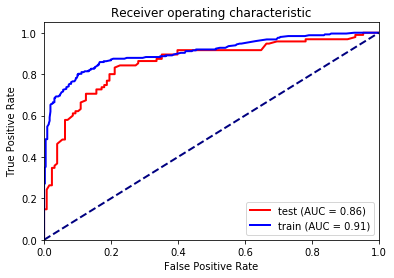

In [0]:
# Calcula o ks para a base de treinamento
best_train_ks = cs.ks(X_train[label_column].as_matrix(), best_train_scores["SCORES"].as_matrix())

# Calcula o ks para a base de teste
best_test_ks = cs.ks(X_test[label_column].as_matrix(), best_test_scores["SCORES"].as_matrix())

# calcula a área da curva roc das bases de treinamento e teste
data = {}
data["train"] = {"label": X_train[label_column], "scores": best_train_scores["SCORES"]}
data["test"] = {"label": X_test[label_column], "scores": best_test_scores["SCORES"]}
best_aucs = cs.roc_curve(data)

best_train_auc = best_aucs['train']
best_test_auc = best_aucs['test']

#### Todos os resultados

In [0]:
data = [['train [xgb simples]', train_auc, train_ks],
        ['train [xgb com grid-search]', best_train_auc, best_train_ks],        
        
        ['test [xgb simples]', test_auc, test_ks],
        ['test [xgb com grid-search]', best_test_auc, best_test_ks]]
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Modelo', 'AUC', 'KS']) 

df.head()

,Modelo,AUC,KS
0,train [xgb simples],0.963221,0.799
1,train [xgb com grid-search],0.905926,0.699
2,test [xgb simples],0.831826,0.582
3,test [xgb com grid-search],0.855551,0.621
